# generate_multitreatment_binary_26()


`generate_multitreatment_binary_26()` defines a **3-arm multi-treatment** observational DGP with correlated confounders and a binary outcome.

Treatments are one-hot columns (`d_0`, `d_1`, `d_2`) and are sampled from a multinomial-logit propensity model calibrated toward target class shares $(0.50,0.25,0.25)$.


## 1. Confounders and Copula Correlation

The confounder vector $X=(X_1,\dots,X_8)$ uses:

- $X_1$ (`tenure_months`) $\sim \mathcal{N}(24,12^2)$, clipped to $[0,120]$
- $X_2$ (`weekly_active_days`) $\sim \mathcal{N}(4.0,1.5^2)$, clipped to $[0,7]$
- $X_3$ (`annual_income_k`) $\sim \text{Gamma}(\text{shape}=4,\text{scale}=18)$, clipped at 300
- $X_4$ (`premium_user`) $\sim \text{Bernoulli}(0.22)$
- $X_5$ (`family_plan`) $\sim \text{Bernoulli}(0.38)$
- $X_6$ (`recent_complaints`) $\sim \text{Poisson}(0.8)$, clipped at 10
- $X_7$ (`discount_eligible`) $\sim \text{Bernoulli}(0.30)$
- $X_8$ (`engagement_score`) $\sim \text{Beta}(\alpha,\beta)$ with mean $0.60$ and concentration $\kappa=16$

Dependencies are induced with Gaussian copula correlation
$$\Sigma_{ij}=0.30^{|i-j|}. $$


## 2. Treatment Assignment (Softmax)

Class scores are
$$s_k(X)=\alpha_k + X^\top\beta_{d,k}, \quad k\in\{0,1,2\},$$
with propensities
$$m_k(X)=\frac{e^{s_k(X)}}{\sum_{j=0}^{2}e^{s_j(X)}}. $$

Scenario coefficients:

- $\beta_{d,0}=\mathbf{0}$
- $\beta_{d,1}=[0.01,0.09,0.0018,0.45,0.20,0.08,0.30,0.28]$
- $\beta_{d,2}=[-0.004,0.07,0.0012,0.30,0.12,0.10,0.18,0.22]$

Treatment-score intercepts start at $(0.0,0.0,0.0)$ and are calibrated to match the target marginal rates.


## 3. Heterogeneous Effects on Logit Scale


Treatment shifts are additive on the link scale:
$$\tau^{link}_k(X)=\theta_k + \tau_k(X), \qquad \theta=(0.0,-0.18,0.26).$$

For `d_1` (enforced harmful relative to control):
$$\tau_1(X)=\min\Big(-0.16 -0.0008\,\text{tenure}-0.020\,\text{activeDays}-0.08\,\text{premium}-0.03\,\text{complaints}-0.10(\text{engagement}-0.60),\,-0.02\Big).$$

For `d_2` (enforced beneficial relative to control):
$$\tau_2(X)=\max\Big(0.14 +0.020\,\text{activeDays}+0.028\log(1+\text{income})+0.05\,\text{familyPlan}-0.010\,\text{complaints}+0.12(\text{engagement}-0.60),\,0.02\Big).$$


## 4. Outcome Model (Binary Logistic)


Baseline logit:
$$\eta_0(X)=\alpha_y + X^\top\beta_y, \qquad \alpha_y=-1.1,$$
where
$$\beta_y=[0.003,0.11,0.004,0.40,-0.25,-0.12,0.20,0.90].$$

Observed logit under assigned treatment:
$$\eta(X,D)=\eta_0(X)+\sum_{k=0}^{2}D_k\,\tau^{link}_k(X).$$

Then
$$P(Y=1\mid X,D)=\sigma(\eta)=\frac{1}{1+e^{-\eta}}, \qquad Y\sim\text{Bernoulli}(\sigma(\eta)).$$


## 5. Oracle Outputs


With `include_oracle=True`, the generated frame includes:

- `m_d_k`: calibrated propensities
- `tau_link_d_k`: link-scale treatment shifts
- `g_d_k`: potential outcome probabilities under each arm
- `cate_d_1`, `cate_d_2`: contrasts vs control on probability scale


In [1]:
from causalis.scenarios.multi_unconfoundedness.dgp import generate_multitreatment_binary_26

df = generate_multitreatment_binary_26(
    seed=42,
    include_oracle=True,
    return_causal_data=False,
)

df.head()

,y,d_0,d_1,d_2,tenure_months,weekly_active_days,annual_income_k,premium_user,family_plan,recent_complaints,...,m_obs_d_1,tau_link_d_1,m_d_2,m_obs_d_2,tau_link_d_2,g_d_0,g_d_1,g_d_2,cate_d_1,cate_d_2
0,1.0,1.0,0.0,0.0,27.656605,2.649000,82.557046,0.0,1.0,0.0,...,0.222533,-0.410269,0.221226,0.221226,0.621091,0.462833,0.363730,0.615892,-0.099103,0.153059
1,1.0,1.0,0.0,0.0,23.798386,2.771811,88.551369,0.0,0.0,2.0,...,0.206692,-0.467589,0.243357,0.243357,0.553028,0.467179,0.354558,0.603855,-0.112621,0.136676
2,1.0,0.0,0.0,1.0,28.425009,2.793864,88.697176,0.0,0.0,0.0,...,0.201852,-0.420776,0.212748,0.212748,0.584368,0.551521,0.446713,0.688086,-0.104807,0.136565
3,1.0,1.0,0.0,0.0,18.860066,3.303381,79.529890,0.0,0.0,1.0,...,0.197248,-0.454976,0.241111,0.241111,0.583534,0.523098,0.410350,0.662844,-0.112748,0.139746
4,0.0,0.0,1.0,0.0,17.853087,2.605056,77.234837,0.0,0.0,0.0,...,0.219363,-0.410719,0.240004,0.240004,0.579375,0.581290,0.479350,0.712477,-0.101940,0.131187


In [3]:
print(f"Ground truth ATE for d_1 vs d_0 is {df['cate_d_1'].mean()}")
print(f"Ground truth ATE for d_2 vs d_0 is {df['cate_d_2'].mean()}")

Ground truth ATE for d_1 vs d_0 is -0.11659127048512116
Ground truth ATE for d_2 vs d_0 is 0.1380607452020492


In [4]:
# wrap it in CausalData
from causalis.data_contracts.multicausaldata import MultiCausalData
multi_causaldata = MultiCausalData(df = df,
                        treatment_names=['d_0', 'd_1', 'd_2'],
                        control_treatment= 'd_0',
                        outcome='y',
                        confounders=['tenure_months',
                                     'weekly_active_days',
                                     'annual_income_k',
                                     'premium_user',
                                     'family_plan',
                                     'recent_complaints',
                                     'discount_eligible',
                                     'engagement_score'])
multi_causaldata

MultiCausalData(df=(100000, 12), treatment_names=['d_0', 'd_1', 'd_2'], control_treatment='d_0')outcome='y', confounders=['tenure_months', 'weekly_active_days', 'annual_income_k', 'premium_user', 'family_plan', 'recent_complaints', 'discount_eligible', 'engagement_score'], user_id=None, 

In [5]:
from causalis.shared.outcome_stats import outcome_stats
outcome_stats(multi_causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,d_0,50162,0.542881,0.498163,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,d_2,25054,0.690389,0.462343,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,d_1,24784,0.439517,0.496338,0.0,0.0,0.0,0.0,1.0,1.0,1.0


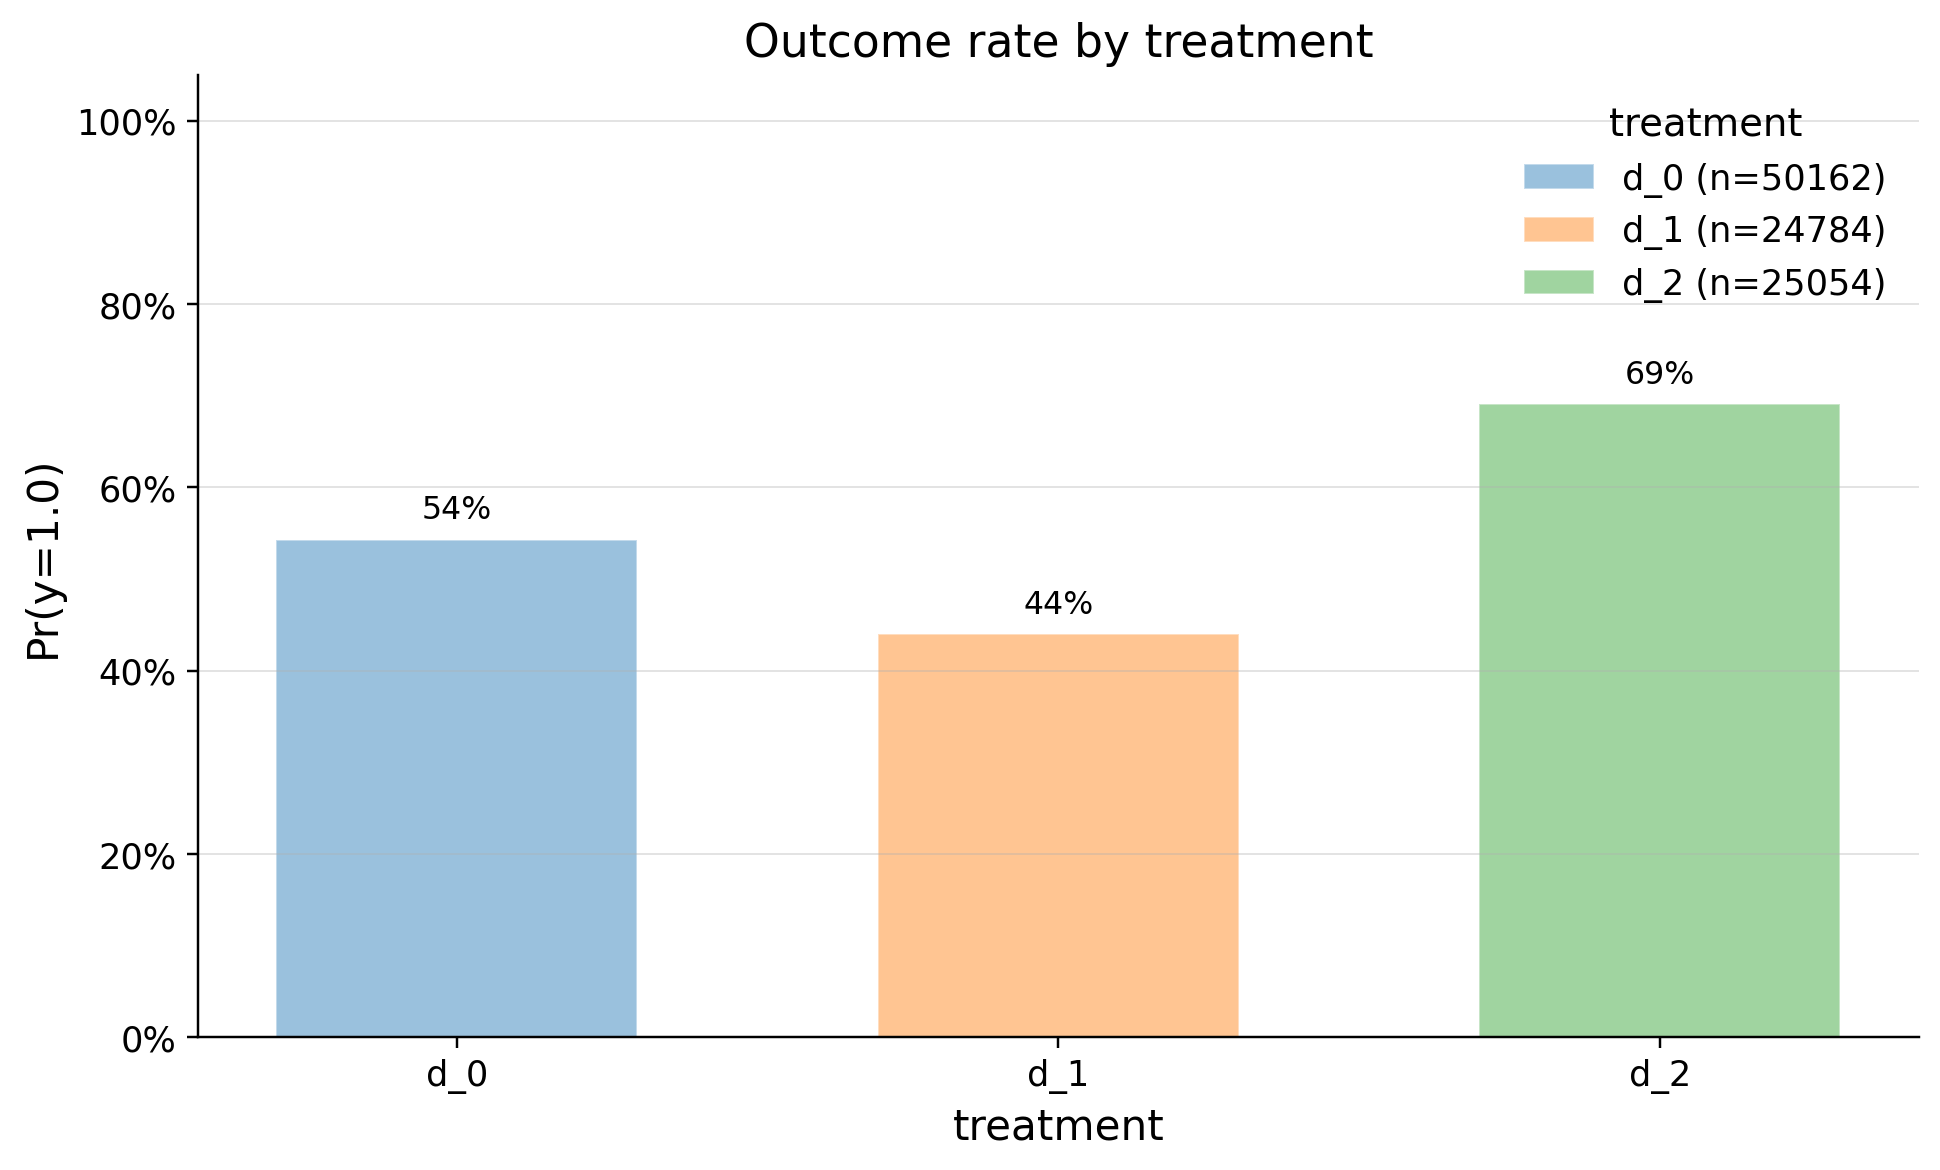

In [6]:
# Statistics for outcome comparison
from causalis.shared import outcome_plot_dist

outcome_plot_dist(multi_causaldata)

In [7]:
from causalis.shared import confounders_balance

confounders_balance(multi_causaldata, 'd_0', 'd_2')

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,premium_user,0.189945,0.240880,0.050935,0.124134,0.00000
1,weekly_active_days,3.903170,4.013747,0.110577,0.075343,0.00000
2,recent_complaints,0.779395,0.845135,0.065740,0.072784,0.00000
3,discount_eligible,0.279116,0.305580,0.026464,0.058207,0.00000
4,family_plan,0.362924,0.390197,0.027273,0.056310,0.00000
5,annual_income_k,70.990667,72.151221,1.160554,0.032499,0.00069
6,tenure_months,23.747821,23.448586,0.299235,-0.025648,0.00111
7,engagement_score,0.599728,0.602376,0.002649,0.022270,0.01979


In [8]:
outcome_plot_dist(multi_causaldata)
from causalis.shared import confounders_balance

confounders_balance(multi_causaldata, 'd_0', 'd_1')

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,premium_user,0.189945,0.263557,0.073613,0.176480,0.00000
1,weekly_active_days,3.903170,4.157551,0.254381,0.174018,0.00000
2,tenure_months,23.747821,25.549990,1.802169,0.153120,0.00000
3,discount_eligible,0.279116,0.335378,0.056262,0.122176,0.00000
4,family_plan,0.362924,0.412565,0.049640,0.102013,0.00000
5,annual_income_k,70.990667,73.516883,2.526216,0.070122,0.00000
6,recent_complaints,0.779395,0.805237,0.025842,0.028893,0.01295
7,engagement_score,0.599728,0.598192,0.001535,-0.012894,0.29411
